# Combined Cycle Power Plant Prediction

**Notebook:** `Combined_Cycle_Power_Plant_Prediction_updated.ipynb`

This notebook contains data loading, EDA, model training (Linear Regression & Random Forest with GridSearchCV), evaluation, plots, and model saving. Run cells sequentially.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# CONFIG
DATAPATHS = ["CCPP_data.csv", "CCPP.csv", "power_plant.csv"]  # try these filenames
RANDOM_STATE = 42
TEST_SIZE = 0.20
CV_FOLDS = 5
SAVE_MODEL_PATH = "rf_final_model.pkl"
RESULTS_CSV = "model_results.csv"
PLOT_AVP = "actual_vs_predicted.png"
PLOT_FI = "feature_importance.png"


## 1. Load dataset (auto-detect filename)

In [2]:
df = None
for p in DATAPATHS:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Loaded data from: {p}")
        break

if df is None:
    raise FileNotFoundError(f"No dataset found. Put your CSV in the working dir and name one of: {DATAPATHS}")

orig_cols = [c.strip() for c in df.columns]
cols_lower = [c.lower().replace(" ","") for c in orig_cols]

col_map = {}
candidates = {
    'at': ['at', 'temperature', 'temp', 't'],
    'v' : ['v', 'vacuum', 'exhaustvacuum', 'exhaust_vacuum'],
    'ap': ['ap', 'ambientpressure', 'ambientpressure', 'pressure'],
    'rh': ['rh', 'relativehumidity', 'humidity'],
    'pe': ['pe', 'poweroutput', 'energyoutput', 'nethourlyelectricalenergyoutput', 'y']
}
for standard, variants in candidates.items():
    for i, c in enumerate(cols_lower):
        for v in variants:
            if v == c or v in c or c in v:
                col_map[standard] = orig_cols[i]
                break
        if standard in col_map:
            break

if len(col_map) < 5:
    print("Column autodetection incomplete — detected columns:")
    print(orig_cols)
    if len(orig_cols) >= 5:
        col_map = {'at': orig_cols[0], 'v': orig_cols[1], 'ap': orig_cols[2], 'rh': orig_cols[3], 'pe': orig_cols[4]}
        print("Falling back to positional mapping:", col_map)
    else:
        raise ValueError("Unable to infer columns automatically. Ensure CSV has AT,V,AP,RH,PE columns or rename headers.")

df = df[[col_map['at'], col_map['v'], col_map['ap'], col_map['rh'], col_map['pe']]].copy()
df.columns = ['AT', 'V', 'AP', 'RH', 'PE']

print('\nDataset shape:', df.shape)
df.head()

Loaded data from: CCPP_data.csv

Dataset shape: (9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,14.96,463.26
1,25.18,62.96,1020.04,25.18,444.37
2,5.11,39.40,1012.16,5.11,488.56
3,20.86,57.32,1010.24,20.86,446.48
4,10.82,37.50,1009.23,10.82,473.90


## 2. Quick EDA
- Correlation matrix and pairplot (sampled if large)

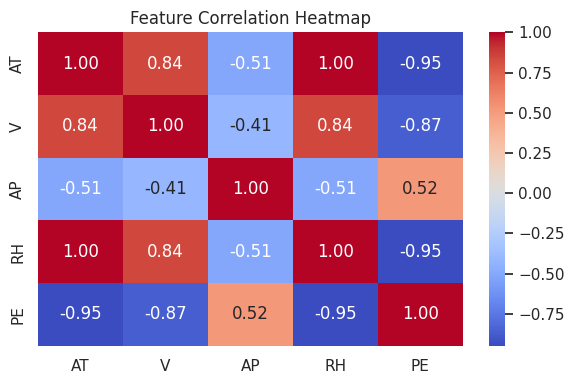

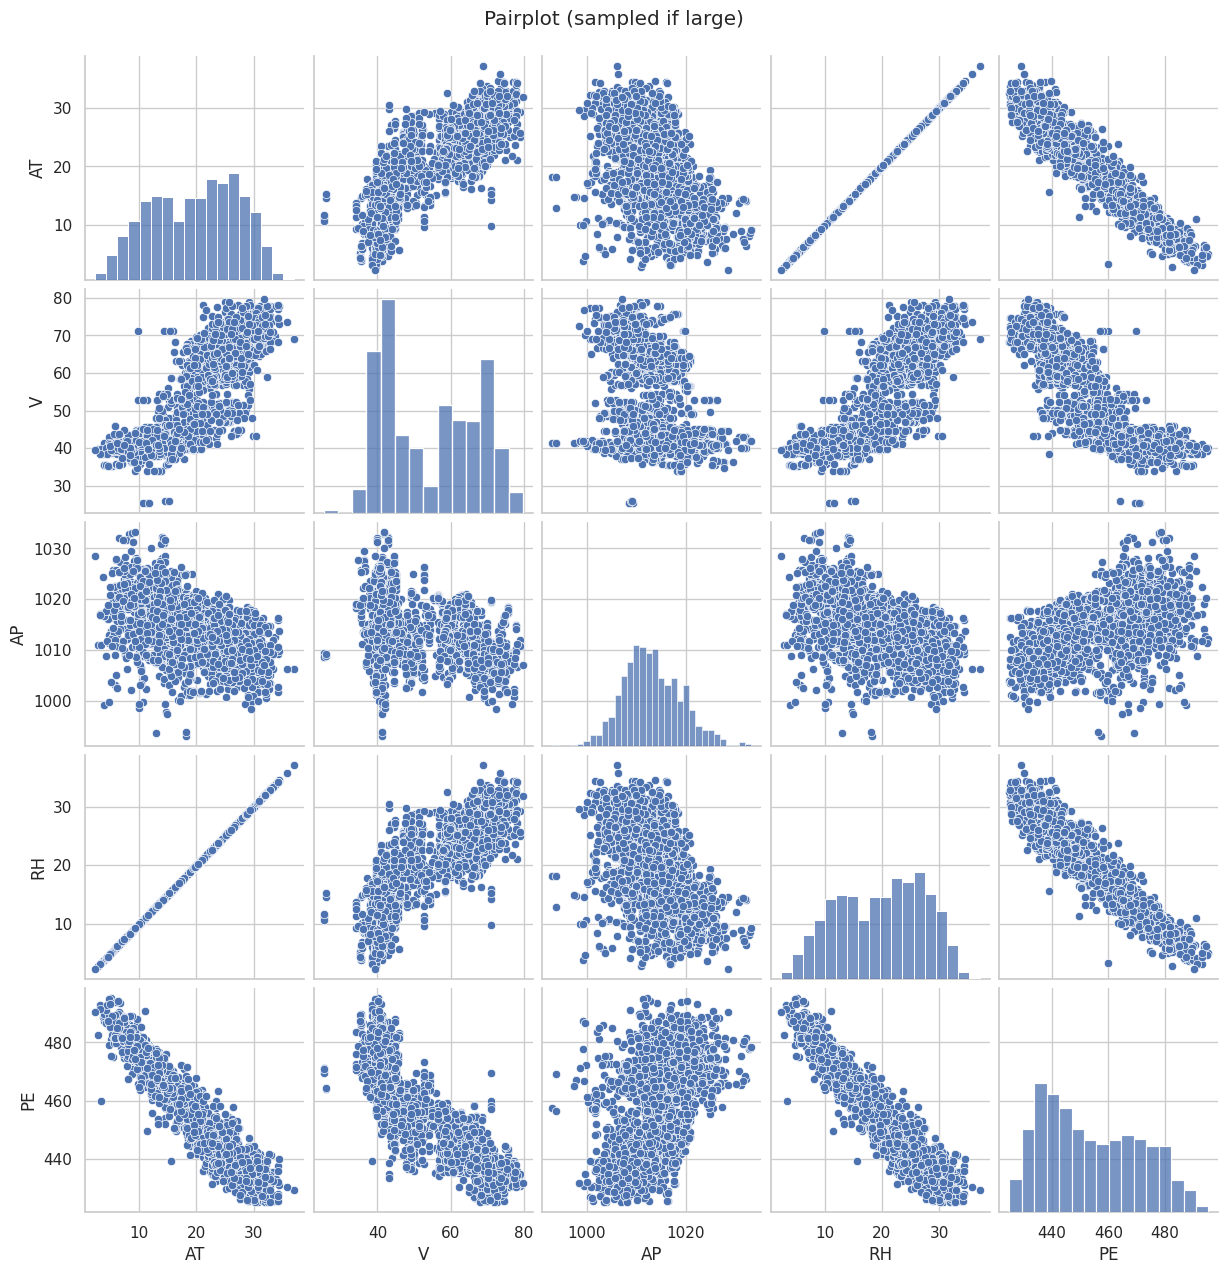

In [3]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

sample = df if len(df) <= 2000 else df.sample(2000, random_state=RANDOM_STATE)
sns.pairplot(sample)
plt.suptitle("Pairplot (sampled if large)", y=1.02)
plt.show()

## 3. Train-test split

In [4]:
X = df[['AT', 'V', 'AP', 'RH']].values
y = df['PE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 7654, Test size: 1914


## 4. Baseline: Linear Regression (with scaling)

In [5]:
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
lr_rmse = math.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)
print(f"Linear Regression test RMSE: {lr_rmse:.4f}, R2: {lr_r2:.4f}")

cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_r2_lr = cross_val_score(pipe_lr, X, y, cv=cv, scoring='r2')
cv_rmse_lr = -cross_val_score(pipe_lr, X, y, cv=cv, scoring='neg_root_mean_squared_error')
print(f"Linear Regression CV R2 mean: {cv_r2_lr.mean():.4f} (+/- {cv_r2_lr.std():.4f})")
print(f"Linear Regression CV RMSE mean: {cv_rmse_lr.mean():.4f} (+/- {cv_rmse_lr.std():.4f})")

Linear Regression test RMSE: 4.8327, R2: 0.9195
Linear Regression CV R2 mean: 0.9178 (+/- 0.0042)
Linear Regression CV RMSE mean: 4.8903 (+/- 0.0868)


## 5. Random Forest with GridSearchCV

In [6]:
pipe_rf = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor(random_state=RANDOM_STATE))])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 8, 12],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(pipe_rf, param_grid, scoring='r2', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best GridSearch params:", grid.best_params_)
best_rf = grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
rf_rmse = math.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest test RMSE: {rf_rmse:.4f}, R2: {rf_r2:.4f}")

cv_r2_rf = cross_val_score(best_rf, X, y, cv=cv, scoring='r2', n_jobs=-1)
cv_rmse_rf = -cross_val_score(best_rf, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f"Random Forest CV R2 mean: {cv_r2_rf.mean():.4f} (+/- {cv_r2_rf.std():.4f})")
print(f"Random Forest CV RMSE mean: {cv_rmse_rf.mean():.4f} (+/- {cv_rmse_rf.std():.4f})")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best GridSearch params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Random Forest test RMSE: 3.3131, R2: 0.9622
Random Forest CV R2 mean: 0.9596 (+/- 0.0027)
Random Forest CV RMSE mean: 3.4289 (+/- 0.0894)


## 6. Model comparison & save results

In [7]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest (tuned)'],
    'Test_RMSE': [lr_rmse, rf_rmse],
    'Test_R2': [lr_r2, rf_r2],
    'CV_RMSE_mean': [cv_rmse_lr.mean(), cv_rmse_rf.mean()],
    'CV_R2_mean': [cv_r2_lr.mean(), cv_r2_rf.mean()]
})

display(results)
results.to_csv(RESULTS_CSV, index=False)
print(f"Saved results to {RESULTS_CSV}")

,Model,Test_RMSE,Test_R2,CV_RMSE_mean,CV_R2_mean
0,Linear Regression,4.832684,0.919482,4.890285,0.917776
1,Random Forest (tuned),3.313094,0.962157,3.428916,0.959555


Saved results to model_results.csv


## 7. Feature importance & interpretation

AP    0.023116
V     0.068597
RH    0.429028
AT    0.479259
dtype: float64


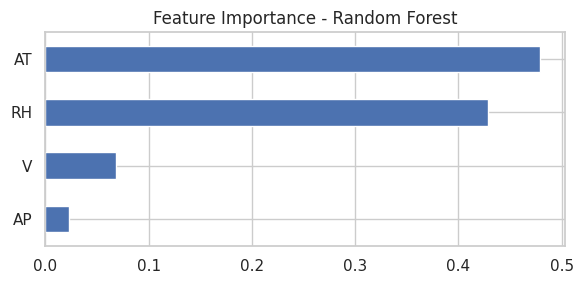


Linear Regression coefficients (directional):
 AT   -6.101593
V    -4.160968
AP    0.928174
RH   -6.101593
dtype: float64


In [8]:
rf_step = best_rf.named_steps['rf']
feat_importances = pd.Series(rf_step.feature_importances_, index=['AT', 'V', 'AP', 'RH']).sort_values(ascending=True)
print(feat_importances)
plt.figure(figsize=(6,3))
feat_importances.plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

lr_coefs = pipe_lr.named_steps['lr'].coef_
coef_series = pd.Series(lr_coefs, index=['AT','V','AP','RH'])
print("\nLinear Regression coefficients (directional):\n", coef_series)

## 8. Plots: Actual vs Predicted & Residuals (and save images)

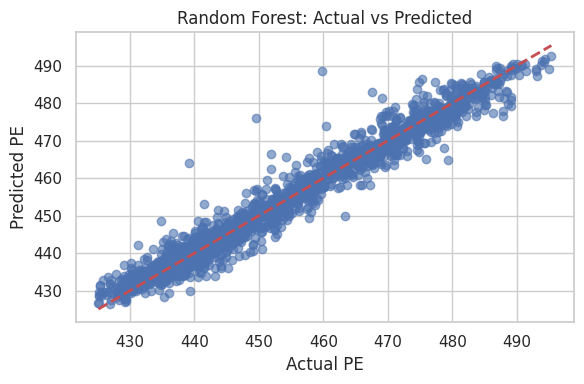

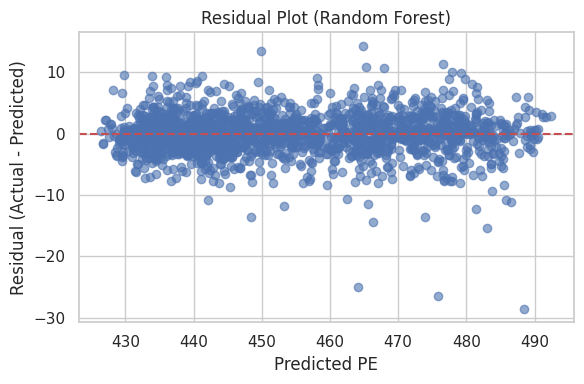

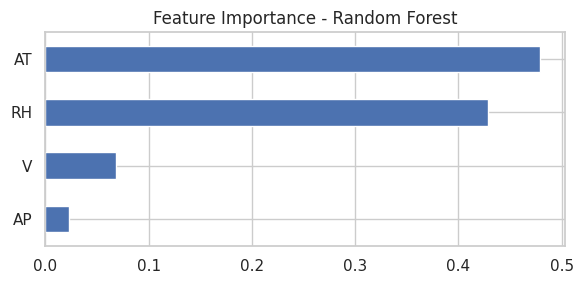

Saved plots: actual_vs_predicted.png, feature_importance.png


In [9]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual PE"); plt.ylabel("Predicted PE"); plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.savefig(PLOT_AVP)
plt.show()

residuals = y_test - y_pred_rf
plt.figure(figsize=(6,4))
plt.scatter(y_pred_rf, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted PE"); plt.ylabel("Residual (Actual - Predicted)"); plt.title("Residual Plot (Random Forest)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
feat_importances.plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.savefig(PLOT_FI)
plt.show()

print(f"Saved plots: {PLOT_AVP}, {PLOT_FI}")

## 9. Save final model

In [10]:
joblib.dump(best_rf, SAVE_MODEL_PATH)
print(f"Saved tuned Random Forest pipeline to: {SAVE_MODEL_PATH}")

Saved tuned Random Forest pipeline to: rf_final_model.pkl


## 10. Conclusion

In [11]:
print('CONCLUSION:')
print(f" - Best model: Random Forest (tuned).")
print(f" - Test RMSE: {rf_rmse:.4f} MW, Test R2: {rf_r2:.4f}")
print(' - Saved model and results files in the working directory.')

CONCLUSION:
 - Best model: Random Forest (tuned).
 - Test RMSE: 3.3131 MW, Test R2: 0.9622
 - Saved model and results files in the working directory.
